# Benchmarking a logical cat qubit processor through the SWAP test
Suppose you have two quantum states, $|\phi\rangle$ and $|\psi\rangle$, and you want to measure how similar they are. Your first reflex could be to measure each state and compare the results. However, the principles of quantum mechanics state that the wavefunction collapses on the state corresponding to the outcome of the measurement, thus potentially destroying the information about the whole state. 
Of course, if you knew how to perfectly prepare the two states, you could repeat the measurement procedure enough times to generate the statistics and then compare them. This procedure is called [state tomography](https://en.wikipedia.org/wiki/Quantum_tomography) and it is perfectly valid, although quite expensive in some cases. 

In fact, let's make the assumption that the two quantum states are the output of a physical process, which is not completely modelled, or, alternatively, of a deep circuit, which is hard to simulate, as, for exemple, a parametrized circuit coming from quantum machine learning.
A simple but effective way of measuring the similarity between two states is the overlap, or scalar product, which quantifies how much the two states are orthogonal to each other. An overlap of 0 means that the states are orthogonal, while an overlap of 1 means that the states are parallel, so equal up to a global phase. The overlap, in bra-ket notation, is written as:
$$\langle\phi|\psi\rangle$$

The swap test is a simple procedure to recover information about the overlap of two states. The circuit is composed of three registers: a control register, and two registers that encode $|\phi\rangle$ and $|\psi\rangle$. The swap test circuit is given below:

<div style="text-align: center;">
  <img src="img/swap-test-circuit.png" alt="title" width="600"/>
</div>

The initial state of the routine is: $|0\rangle|\phi\rangle|\psi\rangle$
The circuit, expressed as tensor product of unitaries, writes:
$$ (H \otimes \mathbf{1} \otimes \mathbf{1}) \text{CSWAP} (H \otimes \mathbf{1} \otimes \mathbf{1})$$

CSWAP, also called Friedkin gate, is the controlled version of the SWAP gate, whose action on two state is:
$$ SWAP|\phi\rangle|\psi\rangle = |\psi\rangle|\phi\rangle $$
The controlled version of the gate, then, will swap the states conditionally on the state of the control qubit, meaning that the swapping is only happening if the control qubit is in the $|1\rangle$ state. Let's analyse the circuit:
- Initial state: $$|\Psi_0\rangle =|0\rangle|\phi\rangle|\psi\rangle$$
- Applying Hadamard gate on first qubit: $$|\Psi_1\rangle = (H \otimes \mathbf{1} \otimes \mathbf{1})|0\rangle|\phi\rangle|\psi\rangle = \frac{|0\rangle+|1\rangle}{\sqrt{2}}|\phi\rangle|\psi\rangle$$
- Applying CSWAP: $$|\Psi_2\rangle = \text{CSWAP}\frac{|0\rangle+|1\rangle}{\sqrt{2}}|\phi\rangle|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle|\phi\rangle|\psi\rangle + |1\rangle|\psi\rangle|\phi\rangle)$$
- Applying Hadamard gate on first qubit: $$|\Psi_3\rangle = (H \otimes \mathbf{1} \otimes \mathbf{1})(\frac{1}{\sqrt{2}}(|0\rangle|\phi\rangle|\psi\rangle + |1\rangle|\psi\rangle|\phi\rangle)) = \frac{1}{2}(|0\rangle|\phi\rangle|\psi\rangle + |1\rangle|\phi\rangle|\psi\rangle + |0\rangle|\psi\rangle|\phi\rangle - |1\rangle|\psi\rangle|\phi\rangle)$$

This is the state after the execution of the circuit, before measurement. Let's measure the first qubit:
$$ P(\text{first qubit} = 0) = \frac{1}{2} + \frac{1}{2}|\langle\phi|\psi\rangle|^2 $$
$$ P(\text{first qubit} = 1) = \frac{1}{2} - \frac{1}{2}|\langle\phi|\psi\rangle|^2 $$
Now two cases arises:
 - If $|\phi\rangle$ and $|\psi\rangle$ are orthogonal, then $\langle\phi|\psi\rangle = 0$ and:
    $$ P(\text{first qubit} = 0) = \frac{1}{2} \qquad P(\text{first qubit} = 1) = \frac{1}{2}   $$
 - If $|\phi\rangle$ and $|\psi\rangle$ are equal, then $\langle\phi|\psi\rangle = 1$ and:
    $$ P(\text{first qubit} = 0) = 1 \qquad P(\text{first qubit} = 1) = 0  $$

Note on the statistics for general states


## Noiseless simulation  

Now, we want to verify our claim with simulations. To do so we will use Qiskit and its Aer simulator. Let's start by instantiating a simulator.


In [12]:
import qiskit
from qiskit_aer import AerSimulator
simulator = AerSimulator()

We prepare the states exploiting arbitrary rotations around the x-axis and z-axis, in the parallel case, and a sequence of NOT gates, in the orthogonal case. This simple preparation is just for illustration purposes, you can change the state preparation to meet your needs, by modifying the function below.

Then, we define a function that creates the quantum circuit for the swap test for an arbitrary size of the registers encoding $|\phi\rangle$ and $|\psi\rangle$. 
We generate the SWAP test circuit and measure the first qubit, as explained.
Note that the SWAP operator on two registers of size `n` is just a sequence of `n` qubit-to-qubit SWAP gates.


In [13]:
def prepare_equal_states(circuit):
    # Prepare \phi
    circuit.rx(theta=0.3, qubit=circuit.qregs[1][0])
    circuit.rz(phi=0.3, qubit=circuit.qregs[1][0])
    circuit.rx(theta=0.1, qubit=circuit.qregs[1][1])

    # Prepare \psi
    circuit.rx(theta=0.3, qubit=circuit.qregs[2][0])
    circuit.rz(phi=0.3, qubit=circuit.qregs[2][0])
    circuit.rx(theta=0.1, qubit=circuit.qregs[2][1])


def prepare_orthogonal_states(circuit):
    # Prepare \phi
    circuit.x(range(1, circuit.qregs[1].size + 1))

In [14]:
def swap_test(n, equal=True):
    # Create the registers
    ctrl = qiskit.QuantumRegister(1, "ctrl")
    q1 = qiskit.QuantumRegister(n, "q")
    q2 = qiskit.QuantumRegister(n, "r")
    c = qiskit.ClassicalRegister(1, "c")

    # Assemble the circuit
    circuit = qiskit.QuantumCircuit(ctrl, q1, q2, c)
    # Prepares the states
    if equal:
        prepare_equal_states(circuit)
    else:
        prepare_orthogonal_states(circuit)

    circuit.h(ctrl)  # Applying a Hadamard gate

    for i in range(n):
        circuit.cswap(ctrl, q1[i], q2[i])  # Contolled SWAP gate bit-to-bit

    circuit.h(ctrl)
    circuit.measure(ctrl, c[0])  # Measuring the qubit

    return circuit

Once we generated the circuit we run it for a large enough number of shots, to recover the statistics.


### Orthogonal states   

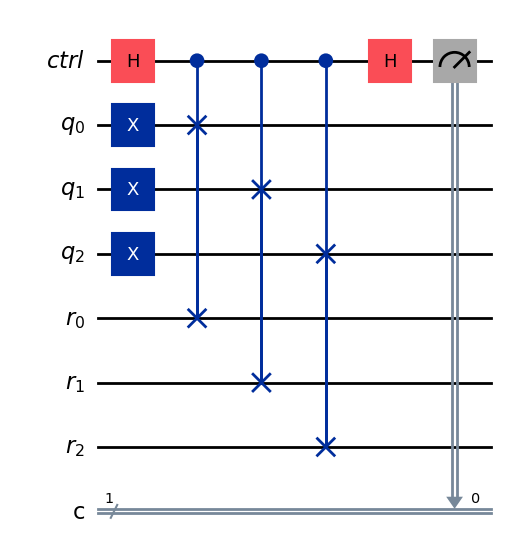

In [15]:
swap_circuit = swap_test(3, False)
swap_circuit.draw('mpl')

In [16]:
shots = 10000
transp_swap_circ = qiskit.transpile(swap_circuit, backend=simulator)
res = simulator.run(transp_swap_circ, shots=shots).result().get_counts()

In [17]:
print("Probability of measuring 0 on the first qubit:", res["0"] / shots)
print("Probability of measuring 1 on the first qubit:", res["1"] / shots)

Probability of measuring 0 on the first qubit: 0.4961
Probability of measuring 1 on the first qubit: 0.5039


### Equal states

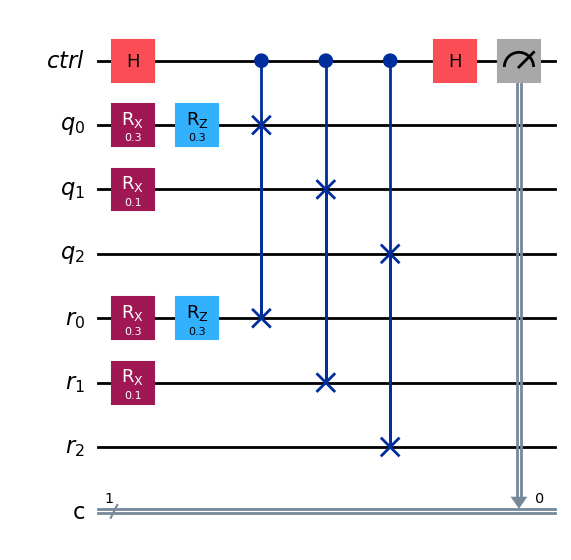

In [18]:
swap_circuit = swap_test(3)
swap_circuit.draw("mpl")

In [19]:
shots = 10000
transp_swap_circ = qiskit.transpile(swap_circuit, backend=simulator)
res = simulator.run(transp_swap_circ, shots=shots).result().get_counts()

In [20]:
print("Probability of measuring 0 on the first qubit:", res["0"] / shots)

Probability of measuring 0 on the first qubit: 1.0


For a noiseless simulation, in the case of equal state, we don't measure any occurencies of the first qubit being in the '1' state.

The probability of measuring '0' spans from $\frac{1}{2}$, for orthogonal states, to 1, for equal states. In order to define the setting for what will follow, we define the probability of failure of the algorithm as being:
$$P_{failure} = 1 - P(\text{first qubit} = 0) $$


In [21]:
print(1 - res["0"] / shots)

0.0


In a noiseless setting, the probability of failure is exactly zero, as it should be. We will choose this quantity to be the relevant metric to evaluate the performance of a noisy backed.


## Noisy simulation
Let's change the rules of the game now, and set the backend to be the [Alice & Bob Qiskit Provider](https://alice-bob.notion.site/Alice-Bob-Felis-documentation-52e554ccbea54e34831761f083883e49?pvs=4), in order to run the code on a cat qubits architechture, on top of which we add the noise model. If you want to know more about cat qubits and why they are great to perform error correction, you can find our series of tutorials that guides you through the peculiarity of the hardware, with [notebooks reproducing experiments](https://github.com/Alice-Bob-SW/felis/tree/main/samples/1_hardware_experiments) and [notebooks running algorithms](https://github.com/Alice-Bob-SW/felis/tree/main/samples/2_algorithms) on the backend.

We start by instantiating our local backend:


In [22]:
from qiskit_alice_bob_provider.local.provider import AliceBobLocalProvider

local = AliceBobLocalProvider()

A noisy backend is prone to errors, which will be revealed in the measurement procedure. Thus, the worst possible cat qubits backend, in this setting, will output '0' and '1' with equal probability, thus making impossible to retrieve information from the SWAP test. Indeed, that of a really noisy backend is the same statistics we would find in the case in which the states are orthogonal. 
This justifies the choice of testing the perfomance of the backend in the case in which the states are equal and using the probability of failure, defined in the previous section, as the relevant metric.

In [23]:
def compute_distance(nb_photons, d, k2, k1=100):

    backend_custom = local.build_logical_backend(
        n_qubits=40,
        distance=d,
        kappa_1=k1,
        kappa_2=k2,
        average_nb_photons=nb_photons,
    )
    num_shots = 10000
    transp_swap_circ = qiskit.transpile(swap_circuit, backend=backend_custom)
    
    # Execute Quantum Program
    res = backend_custom.run(transp_swap_circ, shots=shots).result().get_counts()
    error_rate = 1 - res["0"] / num_shots

    return error_rate

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

distances = [x for x in range(3, 16) if x % 2 != 0]
ratios = [10**x for x in range(3, 8)]
nb_photons = [4, 6, 7, 16]

We plot here the probability of failure as a function of the quality factor of the hardware ($\kappa_2/\kappa_1$) and the ratio between physical qubits and logical qubits, also called the distance of the error correcting code.


In [25]:
# Define the colormap
colors = [(0, 0.5, 0),(0.9,0.5,0), (0.9, 0, 0)]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = "red_darker_green"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

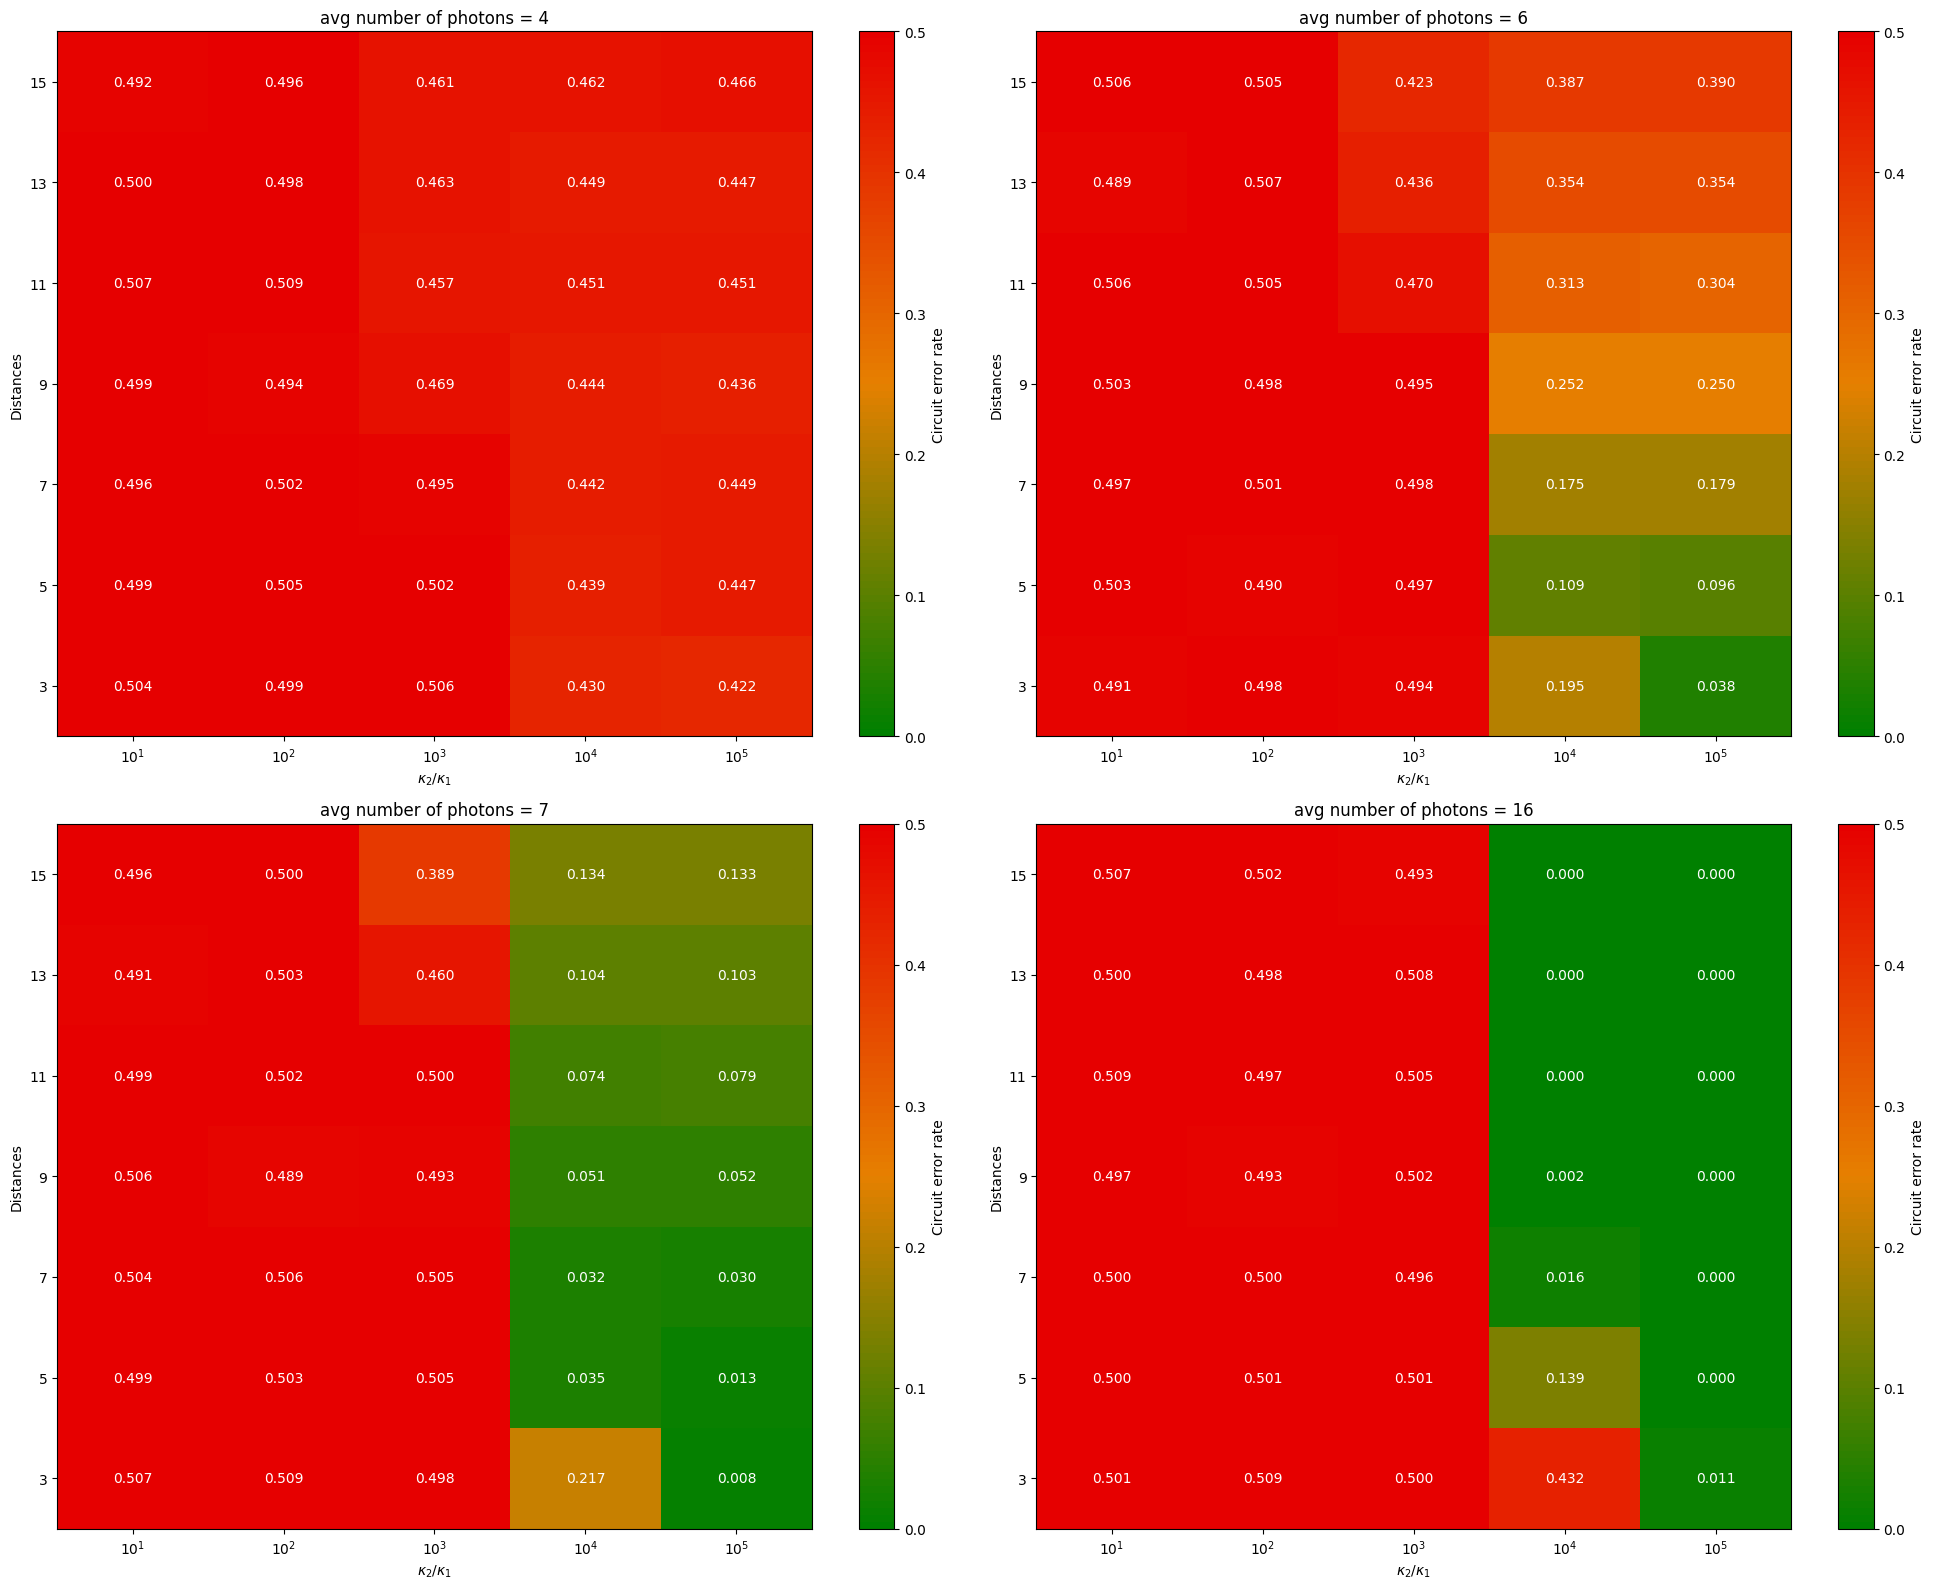

In [26]:
# Number of rows and columns for the subplots
n_rows = len(nb_photons) // 2 + len(nb_photons) % 2
n_cols = 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8 * n_rows))


for idx, nb in enumerate(nb_photons):
    difference = np.zeros((len(distances), len(ratios)))
    for i in range(len(distances)):
        for j in range(len(ratios)):
            difference[i, j] = compute_distance(
                nb_photons=nb, d=distances[i], k2=ratios[j]
            )

    # Create the meshgrid
    ratios_mesh, distances_mesh = np.meshgrid(ratios, distances)
    ratios_mesh_log = np.log10(ratios_mesh)

    # Select the current axis
    ax = axes[idx // n_cols, idx % n_cols] if len(nb_photons) > 1 else axes

    # Plotting
    c = ax.pcolormesh(
        ratios_mesh_log,
        distances_mesh,
        difference,
        shading="auto",
        cmap=cm,
        vmin=0.0,
        vmax=0.5,
    )
    ax.set_xticks(np.log10(ratios))
    ax.set_xticklabels([f"$10^{int(np.log10(r/100))}$" for r in ratios])
    ax.set_yticks(distances)

    # Adding the value on each pixel
    for i in range(len(distances)):
        for j in range(len(ratios)):
            ax.text(
                np.log10(ratios[j]),
                distances[i],
                f"{difference[i, j]:.3f}",
                ha="center",
                va="center",
                color="white",
            )

    fig.colorbar(c, ax=ax, label="Circuit error rate")
    ax.set_xlabel("$\kappa_2/\kappa_1$")
    ax.set_ylabel("Distances")
    ax.set_title(f"avg number of photons = {nb}")

# Adjust layout
plt.tight_layout()
plt.show()

Each figure, except for the one corresponding to $\bar{n} = 4$, presents a clear transition between the region in which error correction does not work (red region) and the region in which it does (green region). The error correction procedure, for cat qubits, takes care of phase flip errors, while bit flip errors are exponentially suppressed with the number of photon in the cavity. You can see on the figures corresponding to $\bar{n} = 6,7, 16$ that increasing the hardware quality above a certain threshold lets you efficiently apply a repetition code and correct phase flips. However, on the figures corresponding to $\bar{n} = 6,7$, increasing the distance of the code, i.e. the number of physical qubits involved in the mapping to one logical qubit, will increase bit flips, making them the primary source of error in the circuit. The first figure corresponding to $\bar{n} = 4$ shows that the physical qubits are not good enough to perform error correction.

### Zooming in on the transition
The transition between a non-error-corrected circuit and an error-corrected circuit, that happens between $\kappa_2/\kappa_1 = 10^3$ and  $\kappa_2/\kappa_1 = 10^4$, looks as sharp as a phase transition. However, this is a resolution issue. Let's try and increase the number of point in the range $\kappa_2/\kappa_1 = [10^3, 10^4]$ and observe the outcome. 


In [27]:
distances = [x for x in range(3, 16) if x % 2 != 0]
ratios = np.linspace(10**5, 10**6, 10)
nb_photons = [4, 6, 7, 12]

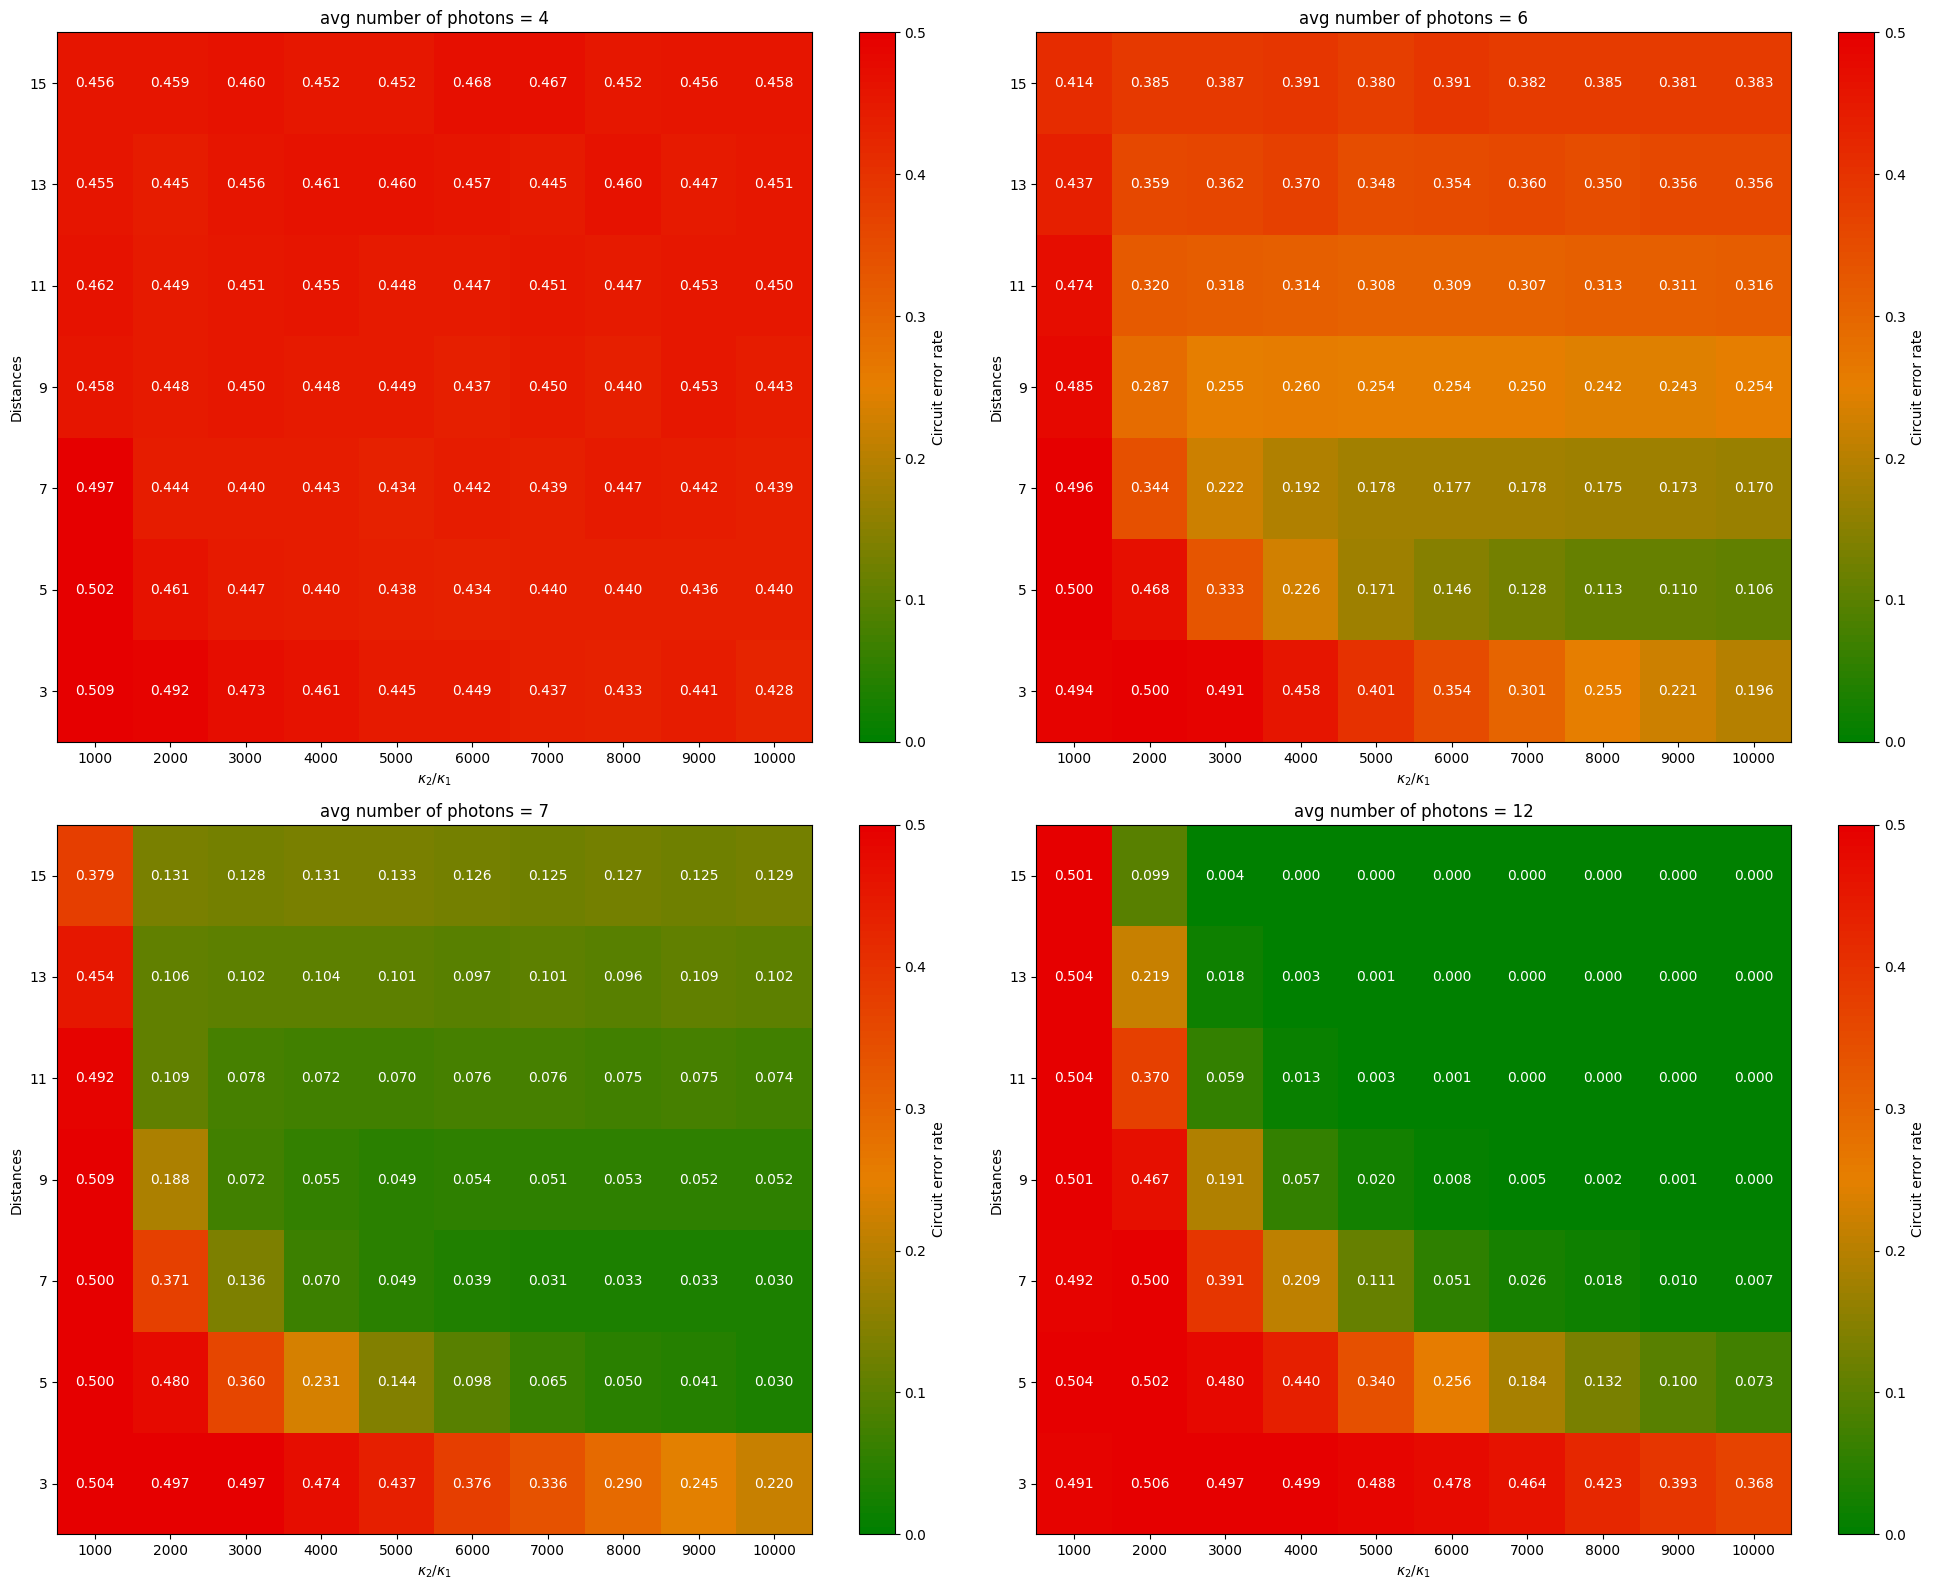

In [28]:
# Number of rows and columns for the subplots
n_rows = len(nb_photons) // 2 + len(nb_photons) % 2
n_cols = 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8 * n_rows))


for idx, nb in enumerate(nb_photons):
    difference = np.zeros((len(distances), len(ratios)))
    for i in range(len(distances)):
        for j in range(len(ratios)):
            difference[i, j] = compute_distance(
                nb_photons=nb, d=distances[i], k2=ratios[j]
            )

    # Create the meshgrid
    ratios_mesh, distances_mesh = np.meshgrid(ratios, distances)
    # Select the current axis
    ax = axes[idx // n_cols, idx % n_cols] if len(nb_photons) > 1 else axes

    # Plotting
    c = ax.pcolormesh(
        ratios_mesh,
        distances_mesh,
        difference,
        shading="auto",
        cmap=cm,
        vmin=0.0,
        vmax=0.5,
    )
    ax.set_xticks(ratios)
    ax.set_xticklabels([f"{int(r/100)}" for r in ratios])
    ax.set_yticks(distances)

    # Adding the value on each pixel
    for i in range(len(distances)):
        for j in range(len(ratios)):
            ax.text(
                ratios[j],
                distances[i],
                f"{difference[i, j]:.3f}",
                ha="center",
                va="center",
                color="white",
            )

    fig.colorbar(c, ax=ax, label="Circuit error rate")
    ax.set_xlabel("$\kappa_2/\kappa_1$")
    ax.set_ylabel("Distances")
    ax.set_title(f"avg number of photons = {nb}")

# Adjust layout
plt.tight_layout()
plt.show()

We choose here to take 10 linearly spaced point, since running the circuit is expensive, and we observe a much smoother transition, as expected. You can increase the number of points even further, and you'll see an even smoother transition.
Moreover, with higher resolution, we can observe phase flips being efficiently corrected increasing the code distance.


### Fixed distance comparison

An interesting phenomenon to observe on the plots above is the fact that, if the cat size is not high enough, bit flips are not completely corrected, even when the hardware becomes virtually noiseless. In fact, the bit flip error the model is not dependend on the quality factor $\kappa_2/\kappa_1$ and is related to the bit flip errors happening during a CNOT (have a look at [this paper, Appendix E, Figure 26](https://arxiv.org/abs/2302.06639) for detailed information about it).

Let's fix the code distance and observe this behaviour:

In [29]:
ratios = np.linspace(10**5, 10**6, 20)
nb_photons_list = [4, 6, 7, 10, 12, 14, 16]  # Example values
distance = 11

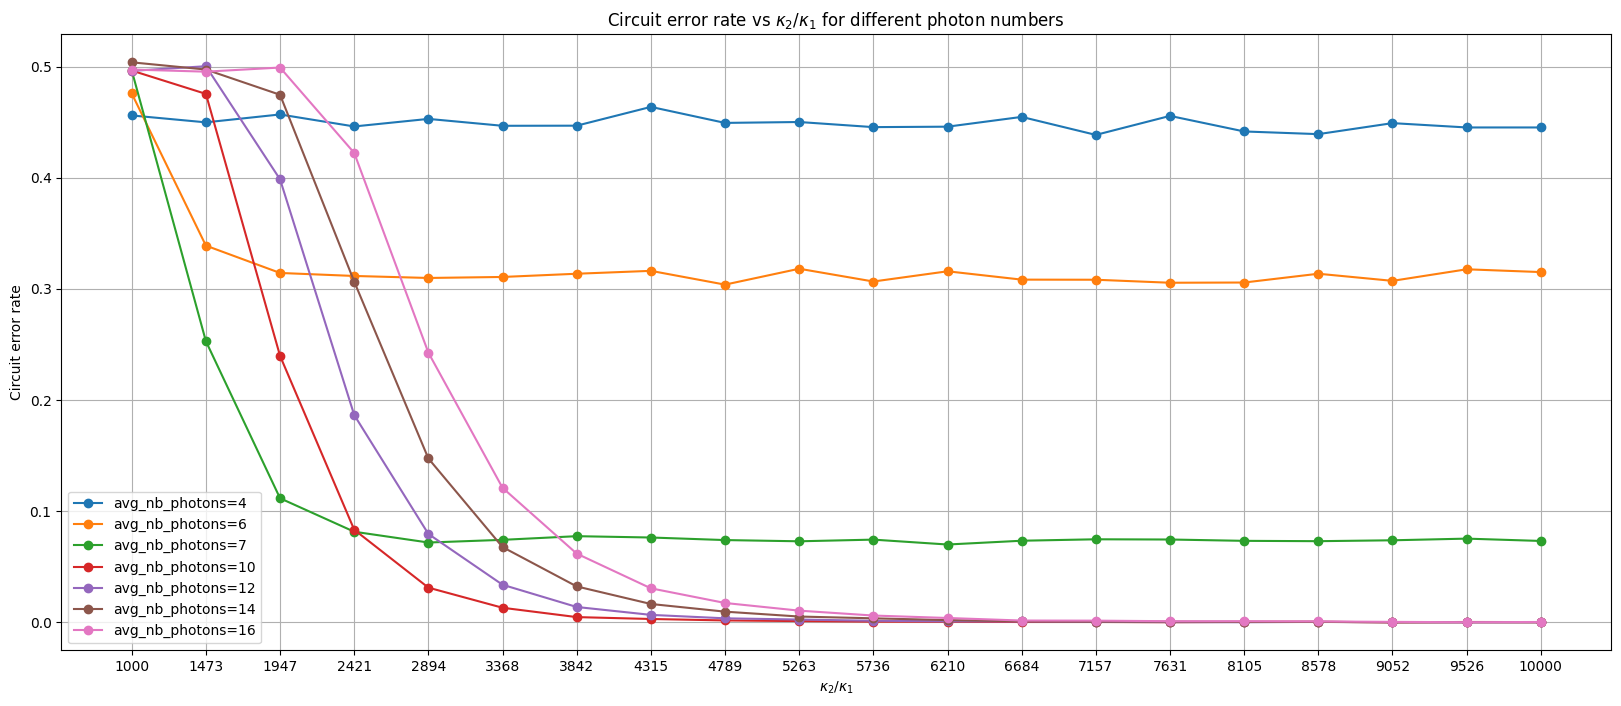

In [30]:
# Plotting
plt.figure(figsize=(20, 8))

diff_list = []

for nb_photons in nb_photons_list:
    # Compute differences for the given parameters
    difference = np.array(
        [
            compute_distance(nb_photons=nb_photons, d=distance, k2=ratio)
            for ratio in ratios
        ]
    )
    diff_list.append(difference)

    plt.plot(ratios, difference, "-o", label=f"avg_nb_photons={nb_photons}")

plt.xticks(ratios, labels=[f"{int(r/100)}" for r in ratios])
plt.xlabel("$\\kappa_2/\\kappa_1$")
plt.ylabel("Circuit error rate")
plt.title("Circuit error rate vs $\kappa_2/\kappa_1$ for different photon numbers")
plt.legend()
plt.grid(True)
plt.show()

Curves corresponding to $\bar{n} = 4,6,7$ show that improving the quality of the hardware allows to efficiently perform error correction and exponentially subpress phase flips; after a certain point, the curve saturates at a constant value corresponding roughly to the bit flip rate. On the other hand, curves corresponding to $\bar{n} = 10,12,14,16$ show that a cat with a large enough size corrects bit flips too.
Increasing the cat size exponentially subpresses bit-flips, but linearly increases phase flips: for this reason, after a certain value of $\bar{n}$, increasing the cat size negligeably improves the bit flip rate, while still considerably worsening phase flips.

##### One-paramater scaling 
For the curves that efficiently correct both types of errors, it is safe to assume that the global behaviour does not depend on the cat size $\bar{n}$ and the hardware quality $\kappa_2/\kappa_1$ separately: this two free parameters could be combindc into one by rescaling the x-axis, i.e. applying the transformation:
$$ \frac{\kappa_2}{\kappa_1} \rightarrow  \frac{1.3 \times 10^{-2}}{\bar{n}^{0.86}}\frac{\kappa_2}{\kappa_1}$$

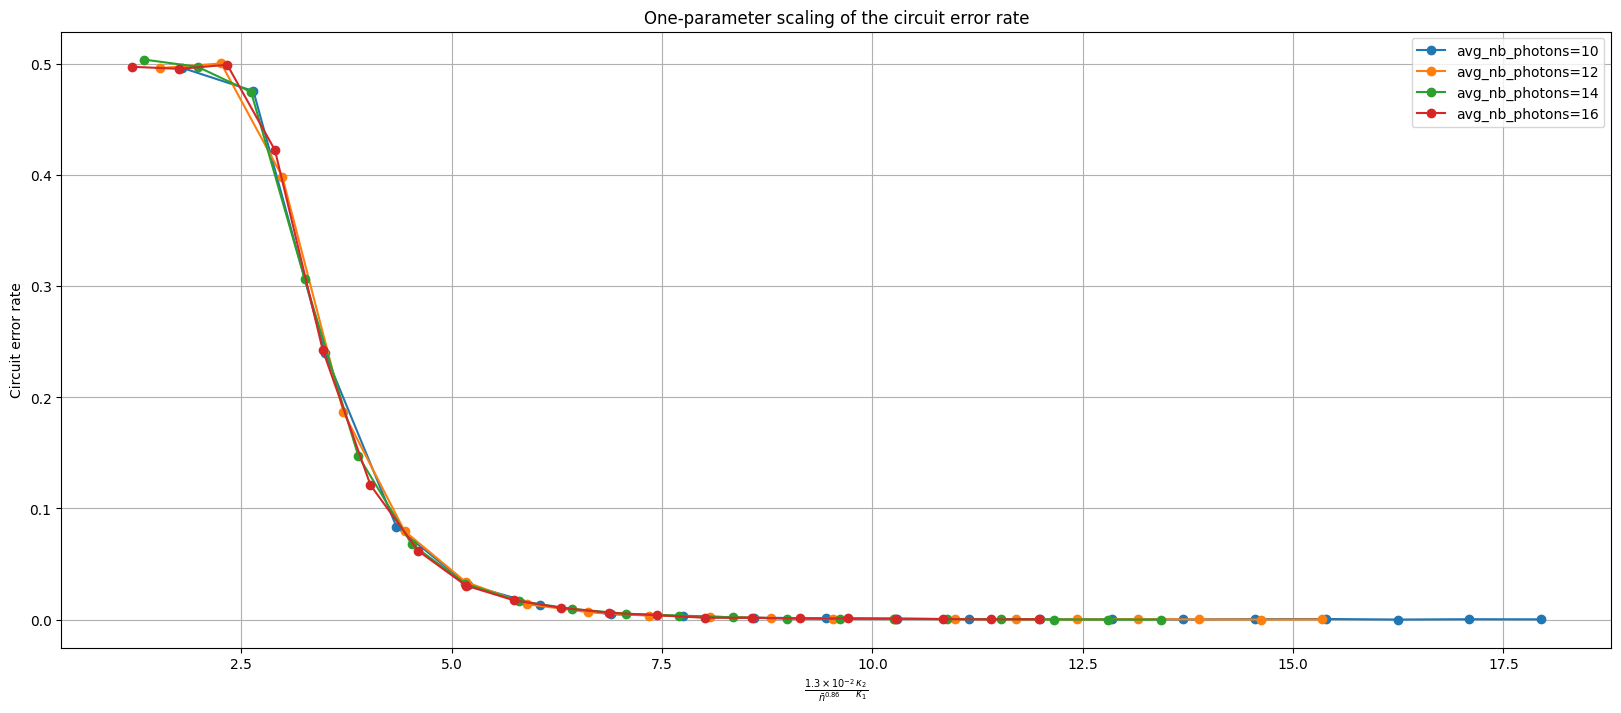

In [43]:
plt.figure(figsize=(20, 8))

for i, difference in enumerate(diff_list[3:]):
    plt.plot(1.3e-2*ratios/(nb_photons_list[i+3])**0.86/100, difference, "-o", label=f"avg_nb_photons={nb_photons_list[i+3]}")

plt.xlabel(r"$ \frac{1.3 \times 10^{-2}}{\bar{n}^{0.86}}\frac{\kappa_2}{\kappa_1}$")
plt.ylabel("Circuit error rate")
plt.title("One-parameter scaling of the circuit error rate")
plt.legend()
plt.grid(True)
plt.show()

As we can see, now the curves are sufficiently superposed. This show the one-parameter scaling of the phenomenon.

##### Errors 
It could also be interesting to see how the circuit error rate behaves as a function of the logical bit flip error and the logical phase flip error. This is shown in the figure below.

In [46]:
from qiskit_alice_bob_provider.processor.logical_cat import (
    _logical_bit_flip_error,
    _logical_phase_flip_error,
)

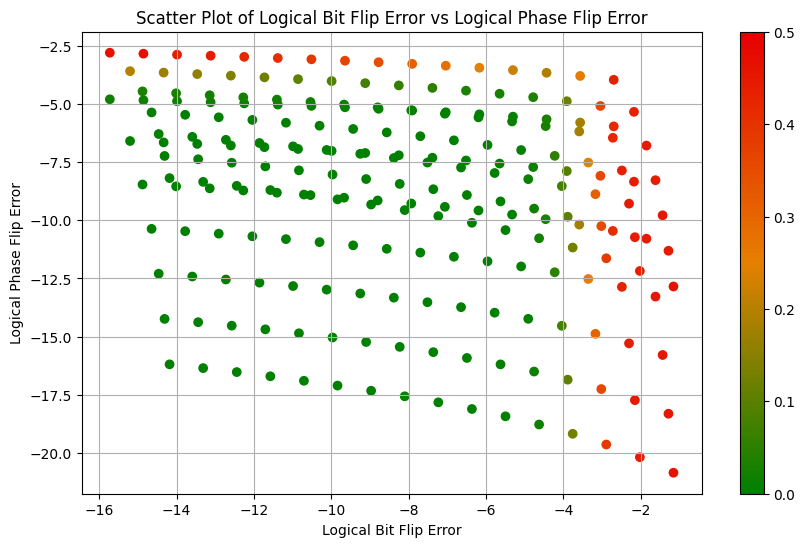

In [45]:
nb_photons = [x for x in range(4,20)]
distances = [x for x in range(3, 16) if x % 2 != 0]
ratios = [10**x for x in range(6, 8)]

# Lists to store the computed errors
bit_flip_errors = []
phase_flip_errors = []
distances_color = []


# Sweep through the parameters and compute errors
for nb in nb_photons:
    for d in distances:
        for k2 in ratios:
            bit_flip_error = _logical_bit_flip_error(d, nb)
            phase_flip_error = _logical_phase_flip_error(d, nb, 100, k2)
            distance_color = compute_distance(nb_photons=nb, d=d, k2=k2)
            bit_flip_errors.append(bit_flip_error)
            phase_flip_errors.append(phase_flip_error)
            distances_color.append(distance_color)

# Generate the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(bit_flip_errors), np.log10(phase_flip_errors), c=distances_color, cmap=cm, vmin=0.0, vmax=0.5)
plt.xlabel('Logical Bit Flip Error')
plt.ylabel('Logical Phase Flip Error')
plt.title('Scatter Plot of Logical Bit Flip Error vs Logical Phase Flip Error')
plt.colorbar()
plt.grid(True)
plt.show()

### Fixed Hardware quality
Now that the analysis of the backend's perfomances is complete, let's look at the optimal parameters to perform error correction with a fixed hardware quality. In [this paper](https://arxiv.org/abs/2401.09541), in order to implement the perfomant LDPC error correction code, they suppose a quality factor of $\kappa_2/\kappa_1 = 10^4$, which is what we are going to use in this next simulation.


In [47]:
distances = [x for x in range(3, 16) if x % 2 != 0]
nb_photons = [x for x in range(4, 20)]
quality_factor = 10**4

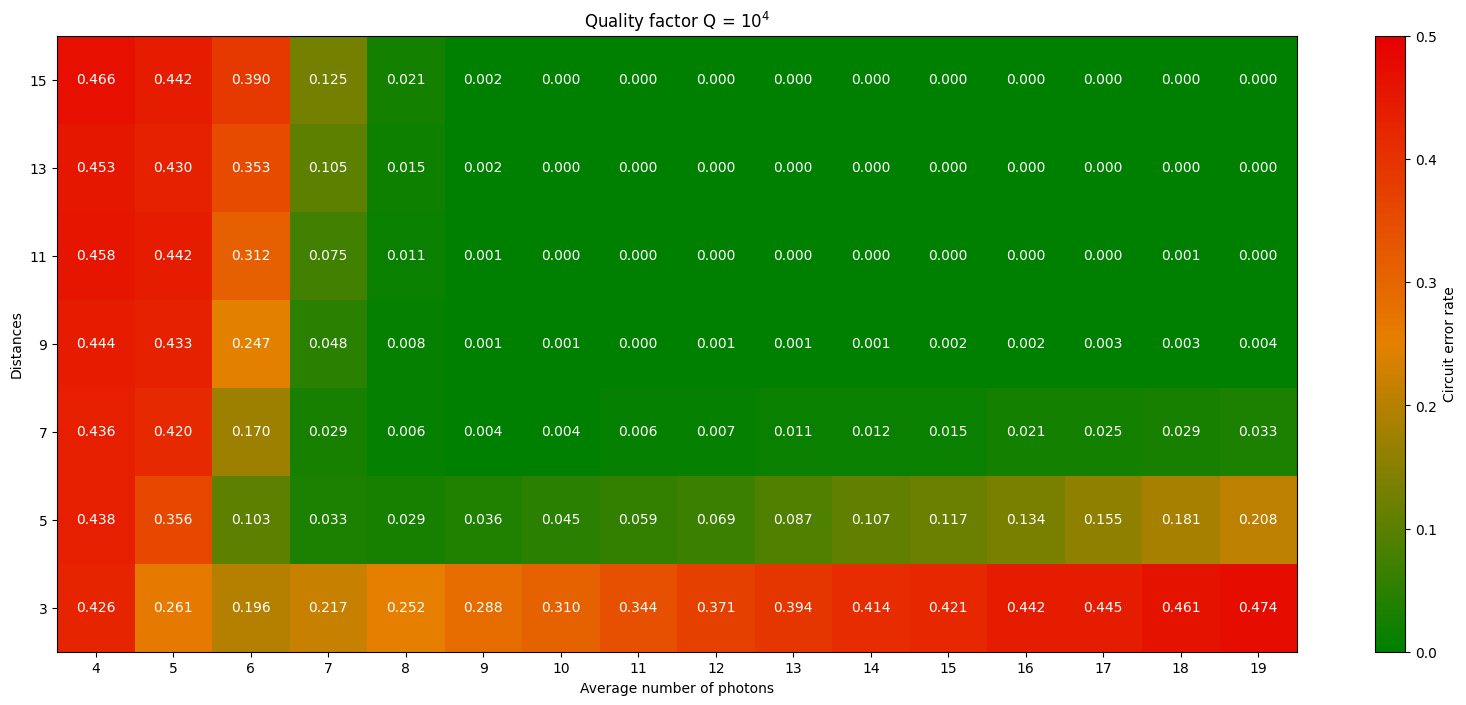

In [48]:
difference = np.zeros((len(distances), len(nb_photons)))
for i in range(len(distances)):
    for j in range(len(nb_photons)):
        difference[i, j] = compute_distance(
            nb_photons=nb_photons[j], d=distances[i], k2=10**6
        )

# Create the meshgrid
photons_mesh, distances_mesh = np.meshgrid(nb_photons, distances)

# Plotting
plt.figure(figsize=(20, 8))
plt.pcolormesh(
    photons_mesh,
    distances_mesh,
    difference,
    shading="auto",
    cmap=cm,
    vmin=0.0,
    vmax=0.5,
)
plt.xticks(nb_photons)
plt.yticks(distances)

# Adding the value on each pixel
for i in range(len(distances)):
    for j in range(len(nb_photons)):
        plt.text(
            nb_photons[j],
            distances[i],
            f"{difference[i, j]:.3f}",
            ha="center",
            va="center",
            color="white",
        )

plt.colorbar(label="Circuit error rate")
plt.xlabel("Average number of photons")
plt.ylabel("Distances")
plt.title(f"Quality factor Q = $10^4$")

plt.show()

The great feature of cat qubits is having a biased noise. Adding more photons will exponentially suppress bit flips while only linearly increase phase
flips. However, for each horizontal line, we reach an optimum, after which increasing the size of the cat by adding more photons negligibly improves the bit flip lifetime but considerably reduces the phase flip lifetime. 
A cat is a beast to be carefully fine-tuned in order to domesticate it.

##### Higher resolution
In order to better locate the optimal number of photons for each code distance, we increase the resolutions of the plot on the x-axis and, after that, we plot the optimal number of photons trend  as a function of code distance.

In [49]:
nb_photons_finer = [round(x * 0.1, 1) for x in range(40, 191)]
distances = [x for x in range(3, 30) if x % 2 != 0]

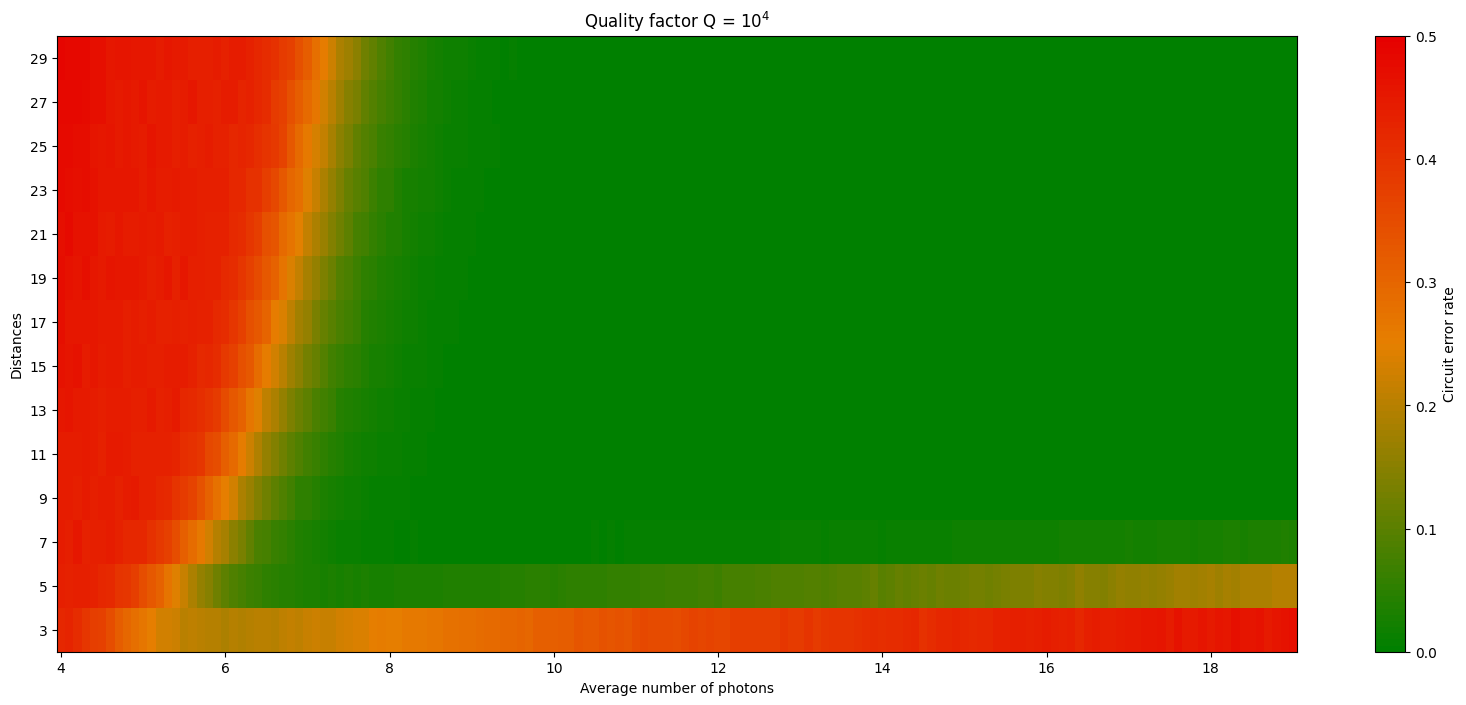

In [50]:
difference = np.zeros((len(distances), len(nb_photons_finer)))
for i in range(len(distances)):
    for j in range(len(nb_photons_finer)):
        difference[i, j] = compute_distance(
            nb_photons=nb_photons_finer[j], d=distances[i], k2=10**6
        )

# Create the meshgrid
photons_mesh, distances_mesh = np.meshgrid(nb_photons_finer, distances)

# Plotting
plt.figure(figsize=(20, 8))
plt.pcolormesh(
    photons_mesh,
    distances_mesh,
    difference,
    shading="auto",
    cmap=cm,
    vmin=0.0,
    vmax=0.5,
)
plt.yticks(distances)

plt.colorbar(label="Circuit error rate")
plt.xlabel("Average number of photons")
plt.ylabel("Distances")
plt.title(f"Quality factor Q = $10^4$")

plt.show()

Finally, we reproduce the plot benchmarking the beckend performance, with a small variation: for each code distance the optimal number of photons, found previously, is used. This plot exemplifies the best perfomance of the logical processor.

In [52]:
distances = [x for x in range(3, 30) if x % 2 != 0]
ratios = np.linspace(10**5, 10**6, 10)

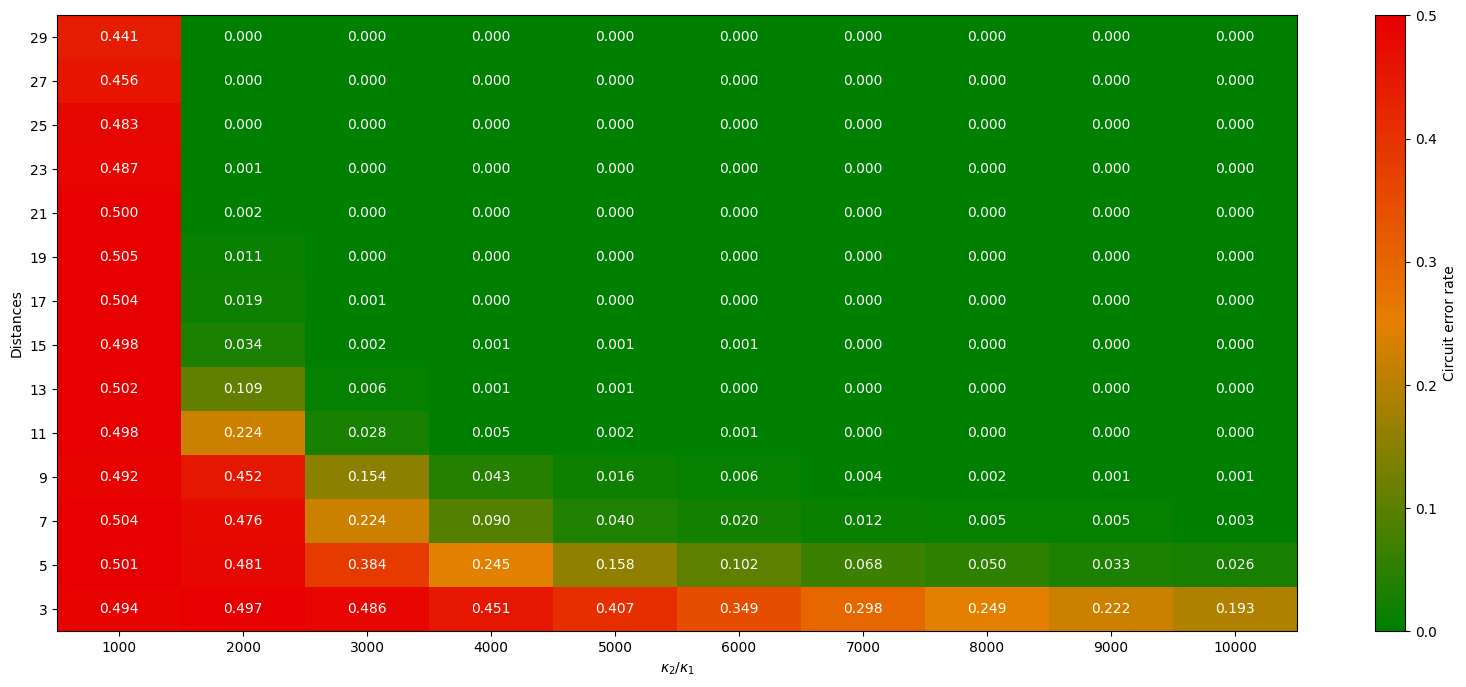

In [53]:
difference = np.zeros((len(distances), len(ratios)))
for i in range(len(distances)):
    for j in range(len(ratios)):
        difference[i, j] = compute_distance(
            nb_photons=optimal_photons[i], d=distances[i], k2=ratios[j]
        )

# Create the meshgrid
ratios_mesh, distances_mesh = np.meshgrid(ratios, distances)

plt.figure(figsize=(20, 8))
plt.pcolormesh(
    ratios_mesh,
    distances_mesh,
    difference,
    shading="auto",
    cmap=cm,
    vmin=0.0,
    vmax=0.5,
)
plt.xticks(ratios, labels=[f"{int(r/100)}" for r in ratios])
plt.yticks(distances)

# Adding the value on each pixel
for i in range(len(distances)):
    for j in range(len(ratios)):
        plt.text(
            ratios[j],
            distances[i],
            f"{difference[i, j]:.3f}",
            ha="center",
            va="center",
            color="white",
        )


plt.colorbar(label="Circuit error rate")
plt.xlabel("$\kappa_2/\kappa_1$")
plt.ylabel("Distances")

plt.show()

As a closing note, we highlight the fact that this simulation is based on the assumption that the statistics of a noise-dominated backend is that of a fair coin, which is the case for a cat qubit architechture. If we would be to switch to a transmon backend, this is no longer true: a noise-dominated backend will output '0' all of the times. This study stays valid also in this case, provided that the swap test is performed on orthogonal states instead of equal ones.